In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "datasets/Hirano3D/"
# data_path = Path(PATH)

In [4]:
_clss = {'NM17-002': 0,
         'Ctrl-AK': 0,
         'GUK1-D': 1, 
         'GUK1-R': 1,
         'MFN2-1': 2,
         'VCP-1': 3}

#### CV generation via sklearn, Multilabel implementation by trent-b, or FastAi

Both libraries seem to be completely useless... can just use native fastai function: get_cv_idxs().<br>
However, get_cv_idxs() does NOT shuffle...!

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_label_stratified_CV_idxs(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_label_stratified_CV_idxs_multi(csv_path):
    
    # FastAi csv_source expects a folder-name string to be passed as first arg... -> 'dummy'
    X, y, all_lbls = csv_source('dummy', csv_path)
    
    ### Iterative stratification library: https://github.com/trent-b/iterative-stratification
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, val_index in msss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    trn_count = np.sum(y[trn_idxs], axis=0)
    val_count = np.sum(y[val_idxs], axis=0)
    
    print(f"""Train label-distribution:\n"""
          f"""{trn_count}""")
    print(f"""Val label-distribution:\n"""
          f"""{val_count}""")
    
    return trn_idxs, val_idxs

In [6]:
### used atm...
csv_path = path + '8bit_multi_folder_Hirano3D_v1.csv'
trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

Train label-distribution:
0    216
1    163
2    161
3    124
dtype: int64
Val label-distribution:
0    54
1    41
2    40
3    31
dtype: int64


In [7]:
import pickle

idxs_dict = {'trn_idxs': trn_idxs, 'val_idxs': val_idxs}

with open('datasets/Hirano3D/tmp/Hirano3D_dn121_local_8bit_idxs.pkl', 'wb') as handle:
    pickle.dump(idxs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('datasets/Hirano3D/tmp/Hirano3D_dn121_local_8bit_idxs.pkl', 'rb') as handle:
    idxs_dict_load = pickle.load(handle)
    
val_idxs_loaded = idxs_dict_load['val_idxs']

In [8]:
# csv_path = path + 'multi_folder_Hirano3D_02.csv'
# trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

In [9]:
# setting up a list of a random 20% of images in train as the validation set

# lbl_csv = path + 'multi_folder_Hirano3D_02.csv'
# n = len(list(open(lbl_csv))) -1
# val_idxs = get_cv_idxs(n, val_pct=0.2)


# # Count labels
# # _all_labels = pd.read_csv(PATH + 'multi_folder_Hirano3D_02.csv')
# # print(_all_labels.Targets.value_counts())

# _arr = _all_labels.values
# _val_labels = pd.DataFrame(_arr[val_idxs], columns=['Id','Targets'])
# print(_val_labels.Targets.value_counts())

### Define Dataloader:

In [10]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'data', lbl_csv, 
                                        val_idxs = val_idxs,
                                        test_name='data/8bit_Hirano3D_MaxP_GRFB_test_512', 
                                        tfms=tfms, bs=bs, suffix = '.tif', 
                                        balance=True, num_workers=0)
    return data

In [11]:
PATH = "datasets/Hirano3D"
# data_path = Path(PATH)

In [12]:
# define augmentations
augs = [RandomDihedral(),RandomRotate(90)]
NUM_CLASSES = 4
bs = 32
sz = [4,224,224]
lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data = get_data(PATH, lbl_csv, val_idxs_loaded, sz, bs, aug_tfms = augs)

Internal Normalization
val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


### inpsect data_loaders

In [ ]:
data.trn_dl.dataset.transform.tfms

In [ ]:
x, y = next(iter(data.trn_dl))
im = to_np(x[0])
im.shape

In [ ]:
x, y = next(iter(data.val_dl))
# x_test, y_test = next(iter(data.test_dl))

In [ ]:
x[0].shape

In [ ]:
# print transformations
# plt.style.use('seaborn-white')

c = 0
idx = 0
fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [ ]:
from PIL import Image

In [ ]:
im_raw = tiff.imread('datasets\\Hirano3D\\test_out/fCMT2_02_e3_017.tif')
im_scaled = (im_raw/255)

im_sc_rot = np.moveaxis(im_scaled, 0,-1)

m = np.array(np.mean(im_sc_rot, axis=(0,1)), dtype=np.float32)
s = np.array(np.std(im_sc_rot, axis=(0,1)), dtype=np.float32)

im_scaled_normed = (im_sc_rot - m) / s
m_n = np.mean(im_scaled_normed[0])
s_n = np.std(im_scaled_normed[0])

print(np.mean(im_raw[0]))
print(np.mean(im_scaled[0]))
print(np.max(im_scaled_normed[0]))
print(m)

print(m_n, s_n)

im_raw.shape

In [ ]:
tiff.imshow(im_raw[0])

In [ ]:
# inspect images
plt.style.use('seaborn-white')
ch = 0
idx = 0

# im = to_np(x)[idx]
im_rawHPA = tiff.imread('datasets\\Kaggle_HPA_2018\\HPAv18_BGR_test\\1183_51_A11_2.tiff')
im_raw = tiff.imread('datasets\\Hirano3D\\test_out/fCMT2_02_e3_017.tif')
# im_scaled = (im_raw/255)


fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].imshow(im_rawHPA[0])
ax[1].imshow(im_raw[ch])

In [ ]:
ch = 1

print(np.max(im_raw[ch]))
print(np.max(im_rawHPA[ch]))

In [ ]:
print(im_rawHPA[ch])

In [ ]:
plt.imshow(to_np(x)[5][2])

In [ ]:
# loading epoch for manual inspection...

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


### inpsecting loaded images and labels

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_np(y)[idx]
# lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [ ]:
torch.cuda.is_available()

In [13]:
# base-model

arch = dn121_c
# arch = resnet50
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0, pretrained=False)

In [ ]:
learn.summary()

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in learn.models.model.state_dict():
    print(param_tensor, "\t", learn.models.model.state_dict()[param_tensor].size())

In [15]:
import copy

def check_model_loading(learn_obj, loaded_state_dict):
    learn_weight0 = list(copy.deepcopy(learn_obj.models.model.state_dict()).items())[0] # need deepcopy here
    learn_weight10 = list(copy.deepcopy(learn_obj.models.model.state_dict()).items())[604] # need deepcopy here

    learn_obj.models.model.load_state_dict(loaded_state_dict, strict=False)
    learn_weight0_loaded = list(learn_obj.models.model.state_dict().items())[0]
    learn_weight10_loaded = list(learn_obj.models.model.state_dict().items())[604]

#     print('weights_0:')
#     print(learn_weight0[1][0] - learn_weight0_loaded[1][0])
#     print('weights_10:')
#     print(learn_weight10[1][0] - learn_weight10_loaded[1][0])

In [16]:
saved_state_dict_path = 'datasets/Hirano3D/models/HPAv18_bs64_sz256_rCrp_dn121_v2_2_val_009.h5'
loaded_state_dict = torch.load(saved_state_dict_path)

In [17]:
# truncating saved model_state_dict()

loaded_state_dict_trunc = copy.deepcopy(loaded_state_dict)
del_keys = list(loaded_state_dict_trunc.keys())[604:]
for key in del_keys: del loaded_state_dict_trunc[key]

print('loaded_state_dict # keys: ', len(loaded_state_dict.keys()))    
print('loaded_state_dict_trunc # keys: ', len(loaded_state_dict_trunc.keys()))    

# Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in learn.models.model.state_dict():
#     print(param_tensor, "\t", learn.models.model.state_dict()[param_tensor].size())

loaded_state_dict # keys:  616
loaded_state_dict_trunc # keys:  604


In [18]:
arch = dn121_c

learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0.5, pretrained=False)
check_model_loading(learn, loaded_state_dict_trunc)

In [ ]:
# additional parameters

wd=1e-4 # weight-decay/L2 regularization 
# learn.metrics = [accuracy, f1_micro]

In [ ]:
learn.unfreeze()

In [ ]:
lrs = np.array([1e-6,1e-4,1e-3])

In [ ]:
%time learn.fit(lrs, 2, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v1')

In [ ]:
%time learn.fit(lrs, 2, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v1')

In [ ]:
%time learn.fit(lrs, 2, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v2')

In [ ]:
%time learn.fit(lrs, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v3')

In [ ]:
learn.load('Hirano3D_dn121_local_8bit_transfHPA_v2')

In [ ]:
%time learn.fit(lrs, 5, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v4')

In [ ]:
%time learn.fit(lrs, 20, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v4')

In [38]:
# learn.load('Hirano3D_dn121_local_8bit_transfHPA_v2')
learn.load('Hirano3D_dn121_local_8bit_transfHPA_v5')

In [39]:
# learn.unfreeze()
learn.freeze()

In [29]:
lrs = np.array([5e-4, 1e-3, 1e-3])

In [36]:
lr = 1e-4
wd=1e-3
%time learn.fit(lr, 5, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v6')

EPOCH 0 ---------------------------------------- STEP 6                                                                                                                                                                                      
epoch      trn_loss   val_loss   accuracy   
    0      0.878987   0.921638   0.656627  
EPOCH 1 ---------------------------------------- STEP 7                                                                                                                                                                                      
    1      0.845614   0.921284   0.662651  
EPOCH 2 ---------------------------------------- STEP 8                                                                                                                                                                                      
    2      0.85138    0.924892   0.650602  
EPOCH 3 ---------------------------------------- STEP 9                                                      

[array([0.91609]), 0.6445783139711403]

In [40]:
lr = 1e-4
%time learn.fit(lr, 20, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v7')

EPOCH 0 ---------------------------------------- STEP 16                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      0.848831   0.92478    0.638554  
EPOCH 1 ---------------------------------------- STEP 17                                                                                                                                                                                     
    1      0.834446   0.942235   0.620482  
EPOCH 2 ---------------------------------------- STEP 18                                                                                                                                                                                     
    2      0.806108   0.920502   0.63253   
EPOCH 3 ---------------------------------------- STEP 19                                                     

KeyboardInterrupt: 

In [51]:
learn.load('Hirano3D_dn121_local_8bit_transfHPA_v6')
learn.freeze()
wd = 1e-2
lr = 1e-5
%time learn.fit(lr, 3, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_v6.2')

EPOCH 0 ---------------------------------------- STEP 55                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      0.713279   0.914004   0.662651  
EPOCH 1 ---------------------------------------- STEP 56                                                                                                                                                                                     
    1      0.735673   0.921391   0.644578  
EPOCH 2 ---------------------------------------- STEP 57                                                                                                                                                                                     
    2      0.727511   0.911979   0.656627  
appending existing log-files...
log-files saved to: datasets/Hirano3D
appending existing log-files...
log-fil

[array([0.91198]), 0.6566265067422247]

In [81]:
# define augmentations
augs = [RandomDihedral(),RandomRotate(90)]
NUM_CLASSES = 4
bs = 32
sz = [4,512,512]
lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data_512 = get_data(PATH, lbl_csv, val_idxs_loaded, sz, bs, aug_tfms = augs)
learn.set_data(data_512)

Internal Normalization
val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


In [86]:
learn.load('Hirano3D_dn121_local_8bit_transfHPA_v6')
learn.freeze()
wd = 1e-2
lr = 5e-3
%time learn.fit(lr, 3, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_512_v1')

EPOCH 0 ---------------------------------------- STEP 89                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      1.063898   1.39797    0.512048  
EPOCH 1 ---------------------------------------- STEP 90                                                                                                                                                                                     
    1      1.039772   1.445386   0.451807  
EPOCH 2 ---------------------------------------- STEP 91                                                                                                                                                                                     
    2      0.959262   1.092089   0.584337  
appending existing log-files...
log-files saved to: datasets/Hirano3D
appending existing log-files...
log-fil

[array([1.09209]), 0.5843373493975904]

In [87]:
lr = 5e-4
%time learn.fit(lr, 3, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_local_8bit_transfHPA_512_v1')

EPOCH 0 ---------------------------------------- STEP 92                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      0.820503   1.097326   0.548193  
  5%|█████████                                                                                                                                                                                    | 1/21 [00:02<00:58,  2.95s/it, loss=0.825]

KeyboardInterrupt: 

In [ ]:
learn.lr_find2(1e-8)

In [ ]:
learn.sched.plot()

In [ ]:
# define augmentations
augs = [RandomDihedral()]
NUM_CLASSES = 4
bs = 64
sz = [4,256,256]
lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data_64_256 = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)
learn.set_data(data_64_256)

In [ ]:
learn.data.bs

In [ ]:
%time learn.fit(1e-3, 1, cycle_len=4, wds=wd, use_wd_sched=True)

## test-predictions

In [53]:
learn.load('Hirano3D_dn121_local_8bit_transfHPA_v6.2')

In [56]:
learn.freeze_to(3)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 4, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 12544)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('BatchNorm2d-5',
              OrderedDict([('input_shape', [-1, 64

In [ ]:
learn.warm_up(1e-10)

In [ ]:
log_preds, y = learn.predict_with_targs()
preds = np.argmax(log_preds, axis=1)
print(preds)

In [58]:
log_preds, y =  learn.TTA()

[[38  3 12  5]
 [ 1 26  3  3]
 [10  1 29  5]
 [ 3  4  2 21]]


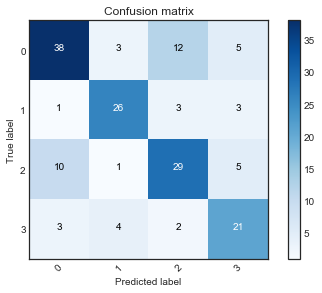

In [59]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(accuracy_score(preds, y))
print(classification_report(preds, y, target_names=data.classes))

In [ ]:
log_preds, y =  learn.TTA(is_test=True)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
print(preds)

In [62]:
learn.models.model._modules

OrderedDict([('0', Sequential(
                (conv0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
                (relu0): ReLU(inplace)
                (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
                (denseblock1): _DenseBlock(
                  (denselayer1): _DenseLayer(
                    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
                    (relu1): ReLU(inplace)
                    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
                    (relu2): ReLU(inplace)
                    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  )
                  (denselayer2): _DenseLayer(
                    

In [63]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [66]:
embeddings = get_embeddings('7')

In [67]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(664, 512)
(166, 512)
(60, 512)
(664,)
(166,)
(60,)


In [68]:
import umap

In [70]:
y_test = np.zeros(60)
y_test[:30] = y_test[:30] +1 
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:
data.test_ds.fnames

['data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_001.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_002.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_003.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_004.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_005.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_006.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_007.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_008.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_009.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_010.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_011.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_012.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_013.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_014.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_015.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_016.tif',
 'data\\8bit_Hirano3D_MaxP_GRFB_test_512\\GUK1-D_017.tif

In [78]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.4,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

In [79]:
# data.test_ds.fnames

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


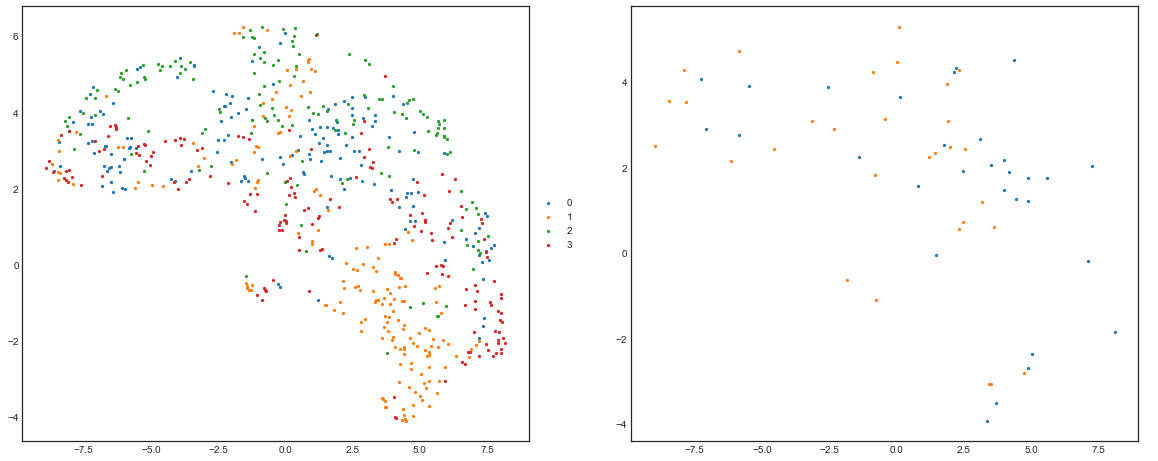

In [88]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(4):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
#     if i == 0:
#         axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)

#     axarr[0].set_xlim(-10,5)
#     axarr[0].set_ylim(-5,8)
    
for i in range(4):
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     axarr[1].set_xlim(-10,5)
#     axarr[1].set_ylim(-5,8)


In [ ]:
def opt_th(preds, targs, start=0.2, end=0.6, step=0.05):
    ths = np.arange(start,end,step)
    res = [f1_macro(preds, targs, thresh=th, kind='macro') for th in ths]
    idx = np.argmax(res)
    return ths[idx], res

In [ ]:
# get train predictions

preds_trn, targs_trn =  learn.predict_with_targs('trn')

preds_trn_torch = torch.from_numpy(preds_trn)
targs_trn_torch = torch.from_numpy(targs_trn)

opt_th(preds_trn_torch, targs_trn_torch)

In [ ]:
print(preds_val_torch[0])
print(preds_trn_torch[0])

In [ ]:
# get val predictions

preds_val, targs_val =  learn.predict_with_targs('val')

preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get test predictions

preds_test, targs_test =  learn.predict_with_targs('test')

In [ ]:
targs_test[:50]

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
data.test_dl.sampler

In [ ]:
test_names = data.test_ds.fnames
test_names[:10]

In [ ]:
def create_submission(preds_file, output_name, th = 0.3, TTA=False):
    
    # creating submission file
    
    if TTA:
        preds = preds_file.mean(axis=0)
        print('TTA:',preds.shape)
    else: preds = preds_file
    
    clss = np.arange(0, len(data.classes)) # get class indeces
    res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > th)])) for p in preds]) # generating output

    # ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
    for i in range(res.shape[0]):
        if res[i] == '':
            res[i] = preds[i].argmax()

    # getting image Ids
    fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

    # creating submission file
    sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
    sub_df.to_csv(output_name, index_label='Id')

In [ ]:
submission_name = PATH + 'submissions/Res18_pre_0.42_t-03.csv'

create_submission(log_preds, submission_name, th=0.3, TTA=True)

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [ ]:
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 1000)
# score = 0.0
# test_threshold=0.5*np.ones(28)
# best_threshold=np.zeros(28)
# best_val = np.zeros(28)
# for i in range(28):
#     for threshold in thresholds:
#         test_threshold[i] = threshold
#         max_val = np.max(preds_y)
#         val_predict = (preds_y > test_threshold)
#         score = f1_score(valid_y > 0.5, val_predict, average='macro')
#         if score > best_val[i]:
#             best_threshold[i] = threshold
#             best_val[i] = score
#     print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
#     test_threshold[i] = best_threshold[i]
# print("Best threshold: ")
# print(best_threshold)
# print("Best f1:")
# print(best_val)